In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../raw_data/site_1.csv')

In [3]:
df.head(5)

,Unnamed: 0,datetime,temperature_1,snowdepth_1,temperature_2,snowdepth_2,temperature_3,snowdepth_3,temperature_4,snowdepth_4,...,temperature_6,snowdepth_6,temperature_7,snowdepth_7,temperature_8,snowdepth_8,temperature_9,snowdepth_9,temperature_10,snowdepth_10
0,0,2015-10-01 00:00:00,11.79,4146.0,12.07,4017.0,12.66,4046.0,NaN,NaN,...,12.47,3706.0,12.26,4043.0,13.06,4307.0,12.50,4257.0,12.04,4174.0
1,1,2015-10-01 00:15:00,11.63,4144.0,11.47,4013.0,12.45,4053.0,NaN,NaN,...,12.16,3693.0,11.96,4027.0,12.76,4302.0,11.71,4251.0,11.57,4163.0
2,2,2015-10-01 00:30:00,10.70,4153.0,11.01,4015.0,11.99,4046.0,NaN,NaN,...,11.55,3704.0,11.46,4030.0,12.06,4307.0,11.24,4254.0,10.59,4162.0
3,3,2015-10-01 00:45:00,10.02,4144.0,10.09,4015.0,10.99,4047.0,NaN,NaN,...,10.72,3705.0,10.69,4029.0,11.31,4305.0,10.48,4252.0,10.08,4163.0
4,4,2015-10-01 01:00:00,9.49,4147.0,9.64,4017.0,10.59,4047.0,NaN,NaN,...,10.24,3705.0,9.92,4027.0,10.80,4303.0,10.05,4256.0,9.38,4167.0


(17569,)


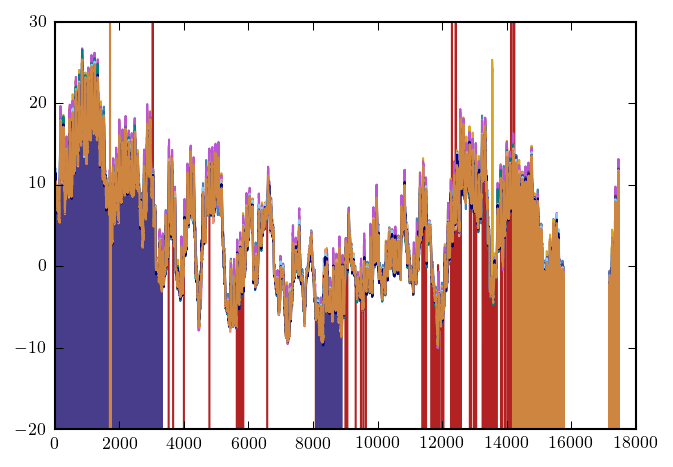

In [80]:
def DetectTempAnomaly(df, window_size, threshold):
    '''
    Return the median abosolute deviation of an observation list over a moving window. 
    
    Parameters
    ----------
    df : pandas dataframe
        The dataframe containing the temp data. 
    window_size: int
        how many observations are included on each side of the target observation. 
    threshold: float
        what is the modified z-score threshold for outliers 
    
    Returns
    -------
    MAD : float array 
        Modified z-score in median abosolute deviations.
    '''
    
    n_nodes = np.sum([1 for col in df.columns if 'temperature' in col])
    temps=[]
    for i in range(1, n_nodes+1):
        temps.append(df['temperature_%i'%i].values)
        temps[i-1][np.isnan(temps[i-1])] = -100
    temps = np.array(temps)
    
    med = np.median(temps, axis=0)
    med_dev = np.median(np.abs(temps-med), axis=0)
    
    print (med/med_dev).shape
    
    return (temps-med)/med_dev
    
df = pd.read_csv('../raw_data/site_10.csv')
med_dev = DetectTempAnomaly(df, 5, 3)


for i in range(1,11):
    plt.plot(df['temperature_%i'%i].values)    
    plt.ylim(-20,30)


    

        

In [116]:
def DifferentialFilter(df):
    n_nodes = np.sum([1 for col in df.columns if 'temperature' in col])
    temps=[]
    for i in range(1, n_nodes+1):
        temps.append(df['temperature_%i'%i].values)
    temps=np.array(temps)
    
    
    
    df_cleaned = df.copy()
    diff = temps[:,1:]-temps[:,:-1]
    for i in range(n_nodes):
        # If the differential is more than two degrees, it is probably very wrong 
        # This is way above the sensor noise level
        # Set these values to NaN
        idx = np.where(diff[i]>2)[0]
        for i_bad in idx:
            temps[i, i_bad-1:i_bad+1] = np.nan
        
        shape = temps.shape        
        means = numpy.nanmean(temps, axis=0)
        flat_diff = (temps-means).flatten()
        flat_temps = temps.flatten()
        # If the temp is more than 10 degrees from the mean intercluster value, this is ridiculous 
        flat_temps[flat_diff>10] = np.nan
        flat_temps[flat_temps>40] = np.nan
        temps = flat_temps.reshape(shape)
        print np.max(flat_temps[~np.isnan(flat_temps)])

        df_cleaned['temperature_%i'%i] = temps[i]
        
    return df_cleaned
        
df = pd.read_csv('../raw_data/site_10.csv')
df_cleaned = DifferentialFilter(df)    


26.74
26.74
26.74
26.74
26.74
26.74
26.74
26.74
26.74
26.74


25.32
26.54
26.74
26.6
25.04
25.25
25.34
25.14
25.41
615.35


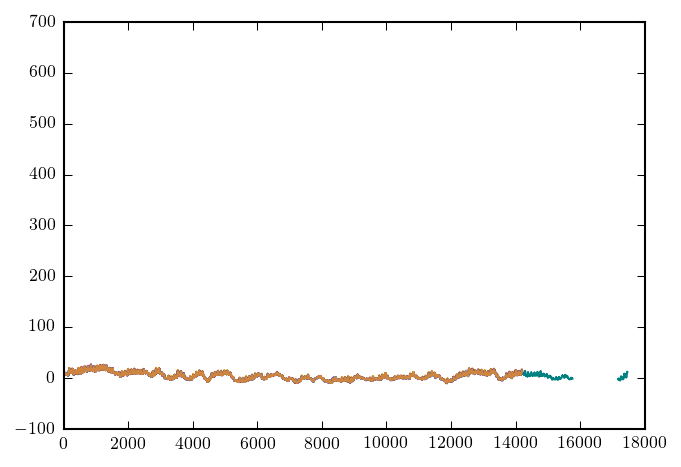

In [124]:

for i in range(1,11):
    plt.plot(df_cleaned['temperature_%i'%i].values)  
    print np.max(df_cleaned['temperature_%i'%i].values[~np.isnan(df_cleaned['temperature_%i'%i].values)])
#     plt.ylim(5,12)
#     plt.xlim(5,100)


In [24]:



def GetMad(x, window_size, threshold):
    '''
    Return the median abosolute deviation of an observation list over a moving window. 
    
    Parameters
    ----------
    x : 1D array
        observation list
    window_size: int
        how many observations are included on each side of the target observation. 
    threshold: float
        what is the modified z-score threshold for outliers 
    
    Returns
    -------
    MAD : float array 
        Modified z-score in median abosolute deviations.
    '''
    # Multithreaded because, why not?
    p = pool.Pool()
    func = partial(GetMAD_Obs, x=x, window_size=window_size ) 
    mod_z = np.array(p.map(func, range(len(x))))
    p.close()
    
#     plt.plot(mod_z)
#     plt.show()
    
    new_obs = x.copy()
    new_obs[mod_z>threshold] = np.nan # set outliers to NaN
    return new_obs
        


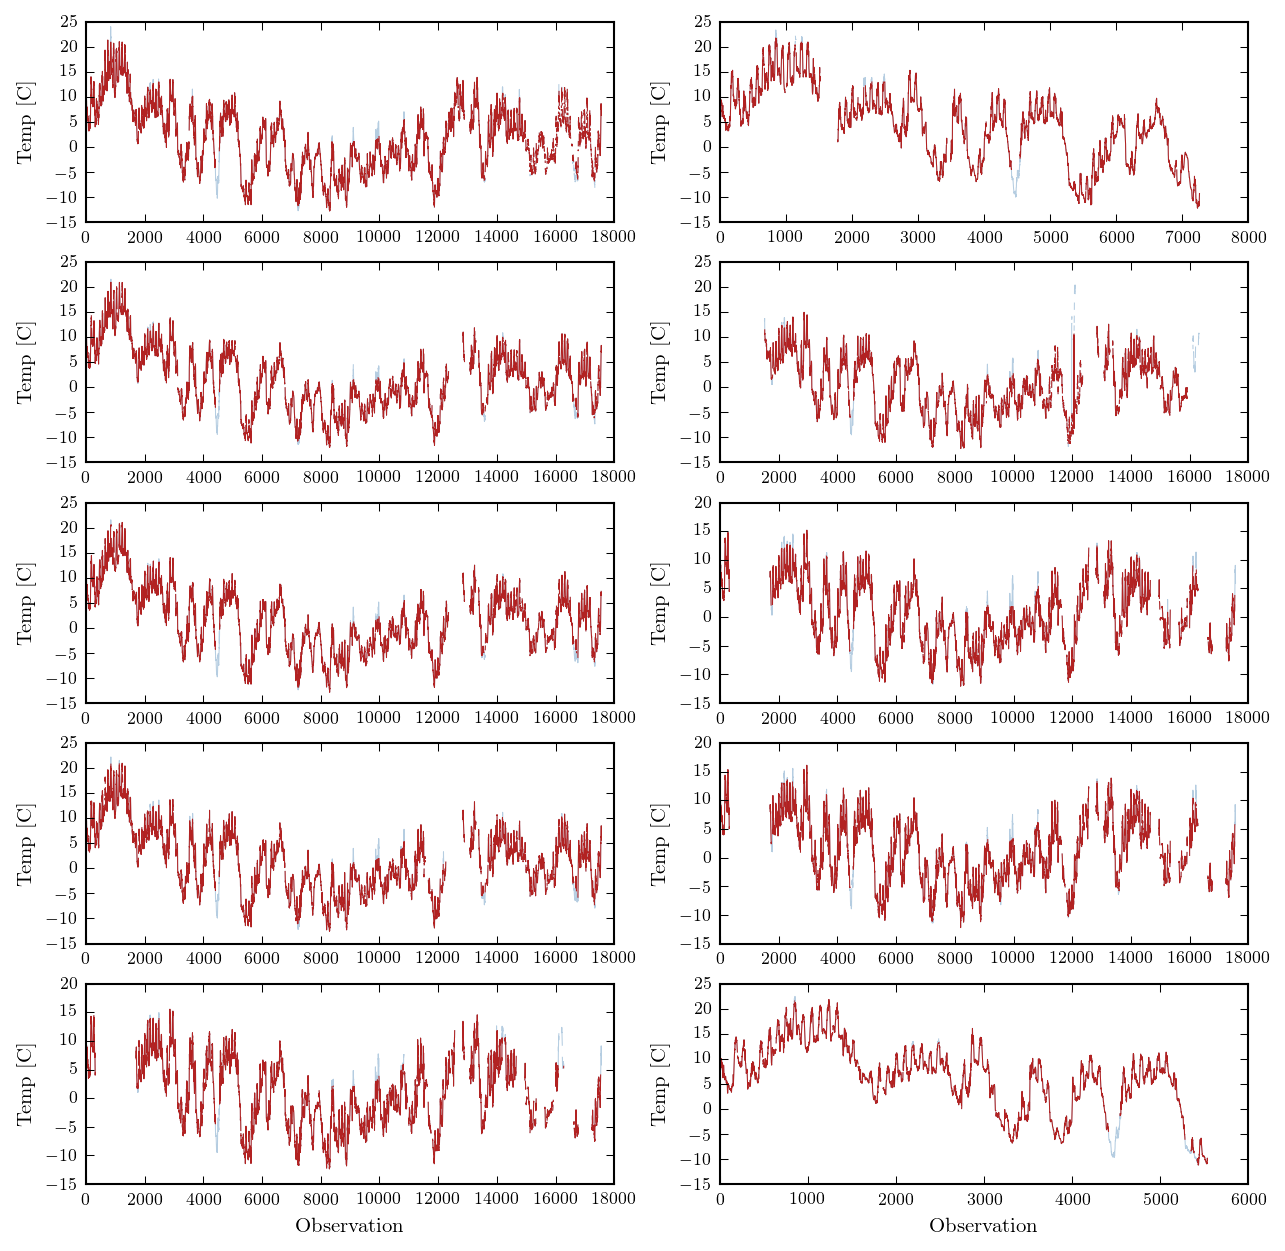

In [28]:
plt.figure(figsize=(10,10))
df_clean = df.copy()

for i in range(1,11):    
    plt.subplot(5,2,i)
    cleaned = GetMad(df['temperature_%i'%i].values[:], window_size=60, threshold=3)
    plt.plot(df['temperature_%i'%i].values, linewidth=.5, alpha=.4)
    df_clean['temperature_%i'%i] = cleaned
    plt.plot(df_clean['temperature_%i'%i], linewidth=.5)
    
    
    plt.ylabel('Temp [C]')
    if i>8:
        plt.xlabel('Observation')

In [23]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


def InterpolateNaNs(y):
    """Fill missing values with interpolation 

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - new, interpolated array
    """
    nans, x= nan_helper(y)
    new = y.copy()
    new[nans] = np.interp(x(nans), x(~nans), y[~nans])
    return new

df_clean_filled = df_clean.copy()
for i in range(1,11):
    df_clean_filled['temperature_%i'%i] = InterpolateNaNs(df_clean_filled['temperature_%i'%i])
    


plt.plot(df_clean_filled['temperature_']-0, label='Clean and Interpolated', alpha=1, color='firebrick')
plt.plot(df_clean['temperature_'], label='Clean', color='steelblue')

# df_clean.to_pickle('../output/cluster_0_cleaned.pickle')
# df_clean_filled.to_pickle('../output/cluster_0_cleaned_filled.pickle')

plt.legend(frameon=False)


NameError: name 'df_clean' is not defined